In [3]:
# 우선, MNIST dataset에 적용할 transformation 객체를 생성합니다.
from torchvision import transforms
import torch
import copy

# transformation 정의하기
data_transform = transforms.Compose([
            transforms.ToTensor(),
])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
# MNIST training dataset 불러오기
from torchvision import datasets

# 데이터를 저장할 경로 설정
path2data = './data'

# training data 불러오기
train_data = datasets.MNIST(path2data, train=True, download=True, transform=data_transform)

# MNIST test dataset 불러오기
test_data = datasets.MNIST(path2data, train=False, download=True, transform=data_transform)

In [6]:
# data loader 를 생성합니다.
from torch.utils.data import DataLoader

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32)

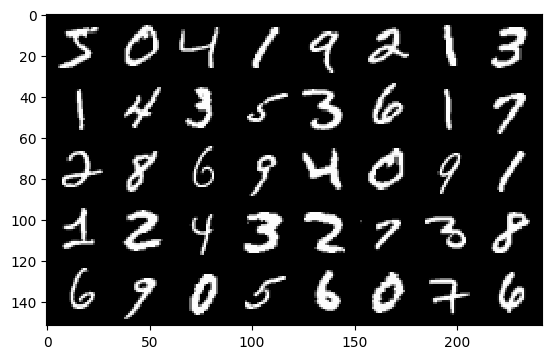

In [7]:
# sample images를 확인합니다.
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training data를 추출합니다.
x_train, y_train = train_data.data, train_data.targets

# val data를 추출합니다.
x_test, y_test = test_data.data, test_data.targets

# 차원을 추가하여 B*C*H*W 가 되도록 합니다.
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)

if len(x_test.shape) == 3:
    x_test = x_test.unsqueeze(1)

# tensor를 image로 변경하는 함수를 정의합니다.
def show(img):
    # tensor를 numpy array로 변경합니다.
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경합니다.
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력합니다.
# 총 40개 이미지, 행당 8개 이미지를 출력합니다.
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2)

show(x_grid)

In [8]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = LeNet_5()
print(model)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [10]:
# 모델 summary를 확인합니다.
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Conv2d-3            [-1, 120, 1, 1]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [11]:
# 배치당 performance metric 을 계산하는 함수 정의
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [12]:
# 배치당 loss를 계산하는 함수를 정의
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [13]:
# epoch당 loss와 performance metric을 계산하는 함수 정의
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True: # sanity_check가 True이면 1epoch만 학습합니다.
            break

    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

In [14]:
# loss function 정의합니다.
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [15]:
# optimizer 정의합니다.
from torch import optim
opt = optim.Adam(model.parameters(), lr=0.001)

# 현재 lr을 계산하는 함수를 정의합니다.
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
# 러닝레이트 스케쥴러를 정의합니다.
#from torch.optim.lr_scheduler import CosineAnnealingLR
#lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)


In [16]:
import time

# train_val 함수 정의
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    #val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    #lr = params['lr']
    #lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }

    # best model parameter를 저장합니다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        epochStartTime = time.time()
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        '''
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')
        '''
        #lr_scheduler.step()
        epoch_calculation_time = time.time() - epochStartTime

        print('train loss: %.6f, calculation time: %0.3f sec'%(train_loss, epoch_calculation_time))
        #print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    # best model을 반환합니다.
    #model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [17]:
params_train = dict()

params_train['num_epochs'] = 30
params_train['loss_func'] = loss_func
params_train['optimizer'] = opt
params_train['train_dl'] = train_dl
#params_train['val_dl'] = val_dl
params_train['sanity_check'] = False
#params_train['lr_scheduler'] = lr_scheduler
params_train['lr'] = 0.001
params_train['path2weights'] = './weights'


# 모델을 학습합니다.
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/29, current lr=0.001


train loss: 0.241538, calculation time: 15.140 sec
----------
Epoch 1/29, current lr=0.001
train loss: 0.082401, calculation time: 15.391 sec
----------
Epoch 2/29, current lr=0.001
train loss: 0.057748, calculation time: 15.524 sec
----------
Epoch 3/29, current lr=0.001
train loss: 0.045470, calculation time: 15.618 sec
----------
Epoch 4/29, current lr=0.001
train loss: 0.036082, calculation time: 15.440 sec
----------
Epoch 5/29, current lr=0.001
train loss: 0.031516, calculation time: 15.841 sec
----------
Epoch 6/29, current lr=0.001
train loss: 0.027093, calculation time: 15.916 sec
----------
Epoch 7/29, current lr=0.001
train loss: 0.023064, calculation time: 15.500 sec
----------
Epoch 8/29, current lr=0.001
train loss: 0.022426, calculation time: 15.363 sec
----------
Epoch 9/29, current lr=0.001
train loss: 0.018698, calculation time: 15.480 sec
----------
Epoch 10/29, current lr=0.001
train loss: 0.016856, calculation time: 15.841 sec
----------
Epoch 11/29, current lr=0.0

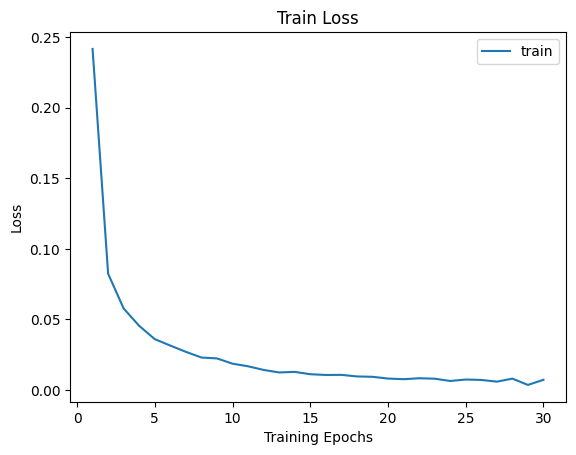

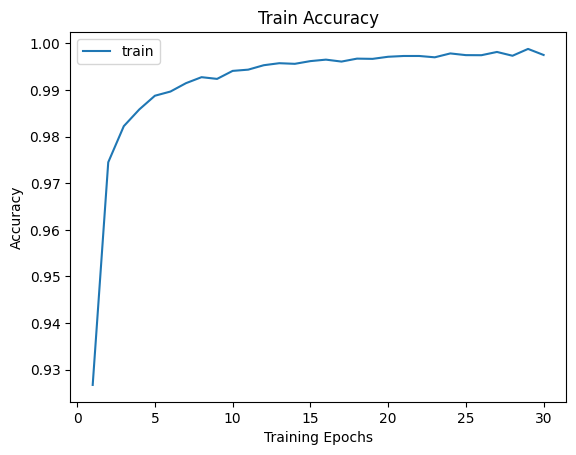

In [18]:
num_epochs=params_train["num_epochs"]

plt.title("Train Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
#plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
#plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [19]:
import os.path
if os.path.isfile(f'./model/epochs-{num_epochs}/LeNet-5_b{32}.pth') == False:
    torch.save(model, f'./model/epochs-{num_epochs}/LeNet-5_b{32}.pth')
else:
    print('cannot save into file.')

cannot save into file.


In [20]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for batch in loader:
            x, y = (b.to(device) for b in batch)
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    

In [21]:
check_accuracy(test_dl, model)

Got 9867 / 10000 with accuracy 98.67


In [22]:
from skimage.util import random_noise
from torchvision.utils import save_image

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


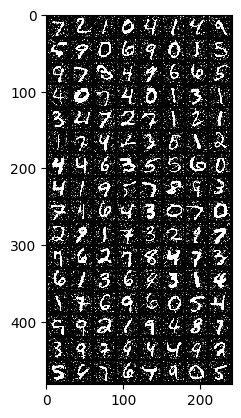

In [23]:

noisy_transform=transforms.Compose([
    #transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0., std=0.6),
])

# MNIST test dataset 불러오기
gau_06_test_data = datasets.MNIST(path2data, train=False, download=True, transform=noisy_transform)
gau_06_test_dl = DataLoader(gau_06_test_data, batch_size=128)
# test data를 추출합니다.
x_test, y_test = gau_06_test_data.data, gau_06_test_data.targets

if len(x_test.shape) == 3:
    x_test = x_test.unsqueeze(1)

for batch in gau_06_test_dl:
    inputs, targets = (b.to(device) for b in batch)
    x_test_grid = utils.make_grid(inputs, nrow=8, padding=2)
    show(x_test_grid.to('cpu'))
    break


# 아래처럼 x_test로 접근하면 transform을 거치기 전 원본 데이터가 시각화 되므로 위의 코드처럼 순환하여 시각화하는 방식을 사용
#x_test_grid = utils.make_grid(x_test[:40], nrow=8, padding=2)
#show(x_test_grid)

In [24]:
check_accuracy(gau_06_test_dl, model)

Got 9175 / 10000 with accuracy 91.75
